### Find the problem of overfitting
- I use learning curve to find the problem of overfitting
- the next step is to adjust the paramter to regularize the model to avoid the problem of overfitting

In [244]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

import sklearn.model_selection as model_selection
from sklearn.model_selection import learning_curve



In [99]:
train_df = pd.read_csv('./input/titanic/train.csv')
test_df = pd.read_csv('./input/titanic/test.csv')
combine = [train_df, test_df]



In [100]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [101]:
train_df.shape

(891, 12)

### my idea about this probelm
Firstly, explore the relationship between each single variable and the survival

And consider the simple model, and then if the simple model is underfitting , then consider complicated model. 

#### First step, consider the age and survival as following
- using histogram?  may be a good choice

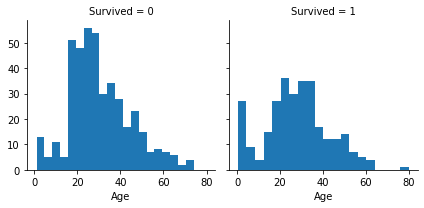

In [102]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

From the distribution above, the young between(20, 30) has a lower survival. While the older(70-80) and the infant has a higher survival. 


In [103]:
#define y variable aka target/outcome
Target = ['Survived']

#define x variables for original features aka feature selection
data1_x = ['Sex','Pclass', 'Embarked','SibSp', 'Parch', 'Age', 'Fare'] #pretty name/values for charts

In [104]:
for x in data1_x:
    if train_df[x].dtype != 'float64' :
        print('Survival Correlation by:', x)
        print(train_df[[x, Target[0]]].groupby(x, as_index=False).mean())
        print('-'*10, '\n')

Survival Correlation by: Sex
      Sex  Survived
0  female  0.742038
1    male  0.188908
---------- 

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: Embarked
  Embarked  Survived
0        C  0.553571
1        Q  0.389610
2        S  0.336957
---------- 

Survival Correlation by: SibSp
   SibSp  Survived
0      0  0.345395
1      1  0.535885
2      2  0.464286
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000
---------- 

Survival Correlation by: Parch
   Parch  Survived
0      0  0.343658
1      1  0.550847
2      2  0.500000
3      3  0.600000
4      4  0.000000
5      5  0.200000
6      6  0.000000
---------- 



In [ ]:
#### My Initial Idea
Choose the simple variable to do the machine learning test 

In [105]:
for dataset in combine:
    dataset.drop(['Name','Ticket','SibSp','Parch','Fare','Cabin', 'PassengerId'], axis = 1, inplace=True)
train_df.head(1)


,Survived,Pclass,Sex,Age,Embarked
0,0,3,male,22.0,S


In [124]:
for dataset in combine: 
    dataset.loc[dataset['Sex']=='male', 'Sex'] = 1
    dataset.loc[dataset['Sex']=='female', 'Sex'] = 2

In [107]:
train_df.head(1)

,Survived,Pclass,Sex,Age,Embarked
0,0,3,1,22.0,S


In [125]:
for dataset in combine:
    dataset.loc[dataset['Embarked']=='C', 'Embarked'] = 1
    dataset.loc[dataset['Embarked']=='Q', 'Embarked'] = 2
    dataset.loc[dataset['Embarked']=='S', 'Embarked'] = 3

In [131]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [136]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i + 1) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
    
    print(guess_ages)
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i + 1) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

[[36.  29.  21.5]
 [35.  28.  21.5]]
[[42. 28. 24.]
 [41. 24. 22.]]


,Survived,Pclass,Sex,Age,Embarked
0,0,3,1,22,3
1,1,1,2,38,1
2,1,3,2,26,3
3,1,1,2,35,3
4,0,3,1,35,3


In [143]:
train_df.shape
train_df = train_df.dropna()

In [164]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test = test_df
X_test.shape

(418, 4)

In [191]:
train1_x, test1_x, train1_y, test1_y = model_selection.train_test_split(X_train, Y_train, random_state = 0)
print(train1_x.shape)
print(test1_x.shape)

(666, 4)
(223, 4)


In [192]:
X_train = train1_x
Y_train = train1_y

In [166]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


79.19

In [167]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.501206
2,Age,-0.033860
3,Embarked,-0.242245
0,Pclass,-1.165095


In [220]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(test1_x)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)

print(acc_svc)
test_accr = calAccuracy(Y_pred, test1_y)
print(test_accr)

86.64
0.757847533632287


//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [169]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.38

In [170]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

77.84

In [171]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

79.19

In [217]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


80.78

In [216]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

90.69

In [174]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

74.35

In [215]:
# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(test1_x)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)
test_accr = calAccuracy(Y_pred, test1_y)
print(test_accr)

90.69
0.7533632286995515


In [176]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
3,Random Forest,89.54
8,Decision Tree,89.54
0,Support Vector Machines,85.71
1,KNN,85.38
7,Linear SVC,79.64
2,Logistic Regression,79.19
5,Perceptron,79.19
4,Naive Bayes,77.84
6,Stochastic Gradient Decent,74.35


In [257]:

# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
test1_predict = random_forest.predict(test1_x)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
print(acc_random_forest)
test_accr = calAccuracy(test1_predict, test1_y)
print(test_accr)
Y_pred = random_forest.predict(test_df)

90.69
0.7623318385650224


#### Plotting learning curve for the model

In [268]:
train_sizes, train_scores, valid_scores = learning_curve(random_forest, X_train, Y_train, train_sizes=[50, 100, 200,300,400], cv=5)
print(train_sizes)
print(train_scores)
print(valid_scores)

[ 50 100 200 300 400]
[[1.         0.94       0.94       0.94       0.94      ]
 [0.97       0.92       0.92       0.92       0.92      ]
 [0.925      0.89       0.92       0.92       0.92      ]
 [0.92666667 0.89666667 0.91333333 0.90666667 0.90666667]
 [0.9275     0.9        0.9125     0.9025     0.905     ]]
[[0.7761194  0.76865672 0.70676692 0.72932331 0.78030303]
 [0.73880597 0.79850746 0.7518797  0.72180451 0.76515152]
 [0.76865672 0.85074627 0.78195489 0.77443609 0.81060606]
 [0.76119403 0.82835821 0.73684211 0.82706767 0.82575758]
 [0.76119403 0.81343284 0.7593985  0.80451128 0.83333333]]


In [269]:
train_scores = train_scores.mean(axis=1)
valid_scores = valid_scores.mean(axis=1)

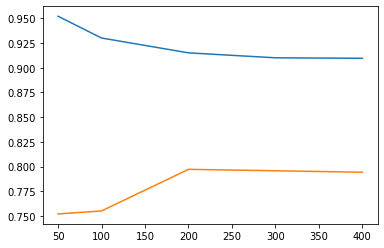

In [270]:
plt.plot(train_sizes, train_scores, label = 'Training error')
plt.plot(train_sizes, valid_scores, label = 'valid_scores error')

In [235]:
def calAccuracy(Y_pred, test1_y):
    res = Y_pred == test1_y
    sum(res == False)
    sum(res == True)
    res = sum(res == True)/float(test1_y.shape[0])
    return res

In [236]:
new_test_df = pd.read_csv('./input/titanic/test.csv')
new_test_df.head(5)
new_test_df.shape
new_test_df['Age'].isnull().sum()
new_test_df.shape

(418, 11)

In [237]:
Y_pred.shape

(418,)

In [238]:
new_test_df = pd.read_csv('./input/titanic/test.csv')

In [239]:
submission = pd.DataFrame({
        "PassengerId": new_test_df["PassengerId"],
        "Survived": Y_pred
    })

In [242]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,0


In [241]:
submission.to_csv("./submit.csv", index=False)


### Improvement
- splitting the data into two parts, one for train, another for cross validation
- try to get to know what's the problem, is it overfitting or underfitting.
- if it is underfitting, adding extra features, which maybe useful
- if overfitting ,may be need to increase regularizaiton 